In [2]:
import numpy as np
import os
from pathlib import Path
#import cv2
import matplotlib.pyplot as plt
from PIL import Image
import joblib
import pickle

#from sklearn.model_selection import train_test_split

#!pip install pytorch-msssim
#from pytorch_msssim import ssim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split

from cfa import colorize_cfa, rgb_kf

In [12]:
def load_images(directory, t = ".png"):
    """
    Load images from dir

    Parameters:
    - directory (str): directory to get data
    - target_size (tuple): expected size of images without channels

    Returns:
    - data (torch.Tensor): A torch stack with the data
    """
    images = []
    for root, dirs, files in os.walk(directory):
        # os.walk returns files in arbitrary order
        for file in sorted(files):
            if file.endswith(t):
                image_path = os.path.join(root, file)
                image_tensor = (
                    torch.Tensor(np.array(Image.open(image_path).convert('RGB'), dtype=np.float32)).permute(2,0,1)
                    if t == ".tiff" or t == ".png"
                    else torch.Tensor(colorize_cfa(np.load(image_path), rgb_kf).astype(np.float32)).permute(2,0,1)
                )

                if image_tensor.max() > 1:
                    image_tensor /= 256.0

                images.append(image_tensor)
    return torch.stack(images)

train_clean = load_images("/home/gustav/Downloads/ds_proc/none-test", t=".png")
train_noise = load_images("/home/gustav/Downloads/ds_proc/tiff-test", t=".tiff")
train_noise.shape, train_clean.shape

(torch.Size([101, 3, 160, 160]), torch.Size([101, 3, 160, 160]))

In [5]:
class PairedDataset(Dataset):
    def __init__(self, data_clean, data_noisy):
        self.data_clean = data_clean
        self.data_noisy = data_noisy

    def __len__(self):
        # Assuming both datasets have the same length
        return len(self.data_clean)

    def __getitem__(self, idx):
        clean_image = self.data_clean[idx]
        noisy_image = self.data_noisy[idx]

        return clean_image, noisy_image

class DenoisingAutoencoder(nn.Module):
    def __init__(self, channels=3):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(True))
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(True))
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(True))
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(True))
        self.enc5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(True))

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout(0.5))
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1), # the 1024 comes from concatenation
            nn.BatchNorm2d(256),
            nn.ReLU(True))
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(True))
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(True))
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1), 
            nn.Tanh())

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)

        # Decoder with skip connections
        d1 = self.dec1(e5)
        d1 = torch.cat((d1, e4), dim=1)  # skip connection
        d2 = self.dec2(d1)
        d2 = torch.cat((d2, e3), dim=1)  # skip connection
        d3 = self.dec3(d2)
        d3 = torch.cat((d3, e2), dim=1)  # skip connection
        d4 = self.dec4(d3)
        d4 = torch.cat((d4, e1), dim=1)  # skip connection
        d5 = self.dec5(d4)
        return d5

In [14]:
model = DenoisingAutoencoder()
model.forward(train_noise[:10]).shape

torch.Size([10, 3, 160, 160])

NameError: name 'tensor_to_image' is not defined

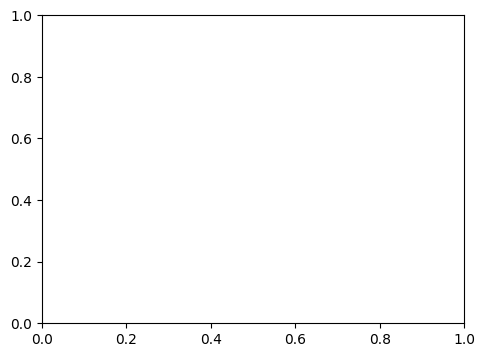

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_image(train_clean[0]))
plt.title(f'Data {train_clean[0].dtype}')
plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(train_noise[0]))
plt.title(f'Gussian {train_noise[0].dtype}')
plt.tight_layout()
plt.show()

In [26]:
def train(train_clean, train_noise, model_dest="/", n_epochs=50):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    paired_dataset = PairedDataset(train_clean, train_noise)
    paired_loader  = DataLoader(paired_dataset, batch_size=32, shuffle=True)
    
    #def ssim_loss(y_true, y_pred):
    #    return 1 - ssim(y_true, y_pred, data_range=1, size_average=True)
    
    model = DenoisingAutoencoder().to(device)
    #criterion = ssim_loss
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    print("Training")
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
    
        for clean_images, noisy_images in paired_loader:
            clean_images, noisy_images = clean_images.to(device), noisy_images.to(device)
    
            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(noisy_images)
            loss = criterion(outputs, clean_images)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        epoch_loss = running_loss / len(paired_loader)
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss}')
        
    for param in model.parameters():
        if torch.isnan(param).any() or torch.isinf(param).any():
            print("Model contains NaN or inf values")
            
    joblib.dump(model, Path(model_dest))

train(train_clean, train_noise, model_dest="/home/gustav/Downloads/ds_proc/test.pkl", n_epochs=1)

Training
Epoch 1/1, Loss: 1.0008522421121597


In [30]:
model = pickle.load(open("/home/gustav/Downloads/ds_proc/test.pkl", "rb"))

In [16]:
def show_validation(inputs_clean, inputs_noise, outputs):
    fig, axs = plt.subplots(3, 3, figsize=(15, 6))
    for i in range(3):
        for n, (title, data) in enumerate([
            ("Target image", inputs_clean),
            ("Input noisy", inputs_noise),
            ("Result image", outputs)
        ]):
            axs[n, i].imshow(data[i].permute(1, 2, 0).squeeze())
            axs[n, i].title.set_text(title + str(i+1))
            axs[n, i].axis('off')

    plt.show()

def validate(model, val_clean, val_noise):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    paired_dataset = PairedDataset(val_clean, val_noise)
    paired_loader  = DataLoader(paired_dataset, batch_size=32, shuffle=False)
    
    model.eval()
    model.to(device)

    criterion = nn.MSELoss()

    losses = []
    with torch.no_grad():
        for n, (inputs_clean, inputs_noise) in enumerate(paired_loader):
            outputs = model(inputs_noise.to(device))
            mse = criterion(outputs, inputs_clean.to(device))
            losses.append(mse)
    
            #if n == 0:
            #   show_validation(inputs_clean.cpu(), inputs_noise.cpu(), outputs.cpu())

    return losses

losses = validate(model, train_clean, train_noise)
[f"{loss}" for loss in losses]

['0.29571714997291565',
 '0.33826544880867004',
 '0.3392800986766815',
 '0.3564023971557617']